## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.


Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course \


Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

<>:2: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_347145/2367876760.py:2: SyntaxWarning: invalid escape sequence '\g'
  """


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

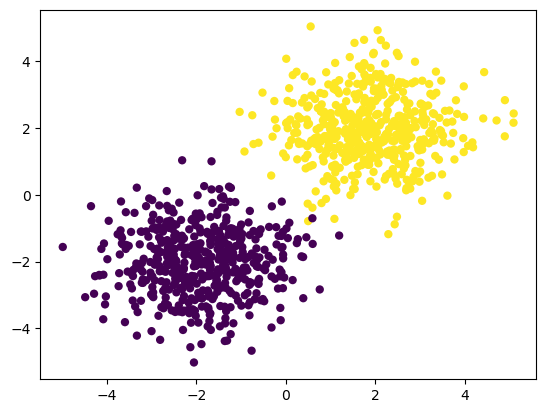

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:

net = Sequential()
net.add(Linear(2, 16))
net.add(ReLU())
net.add(Linear(16, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()
print(net)



Linear 2 -> 16
ReLU
Linear 16 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 256

In [6]:

# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

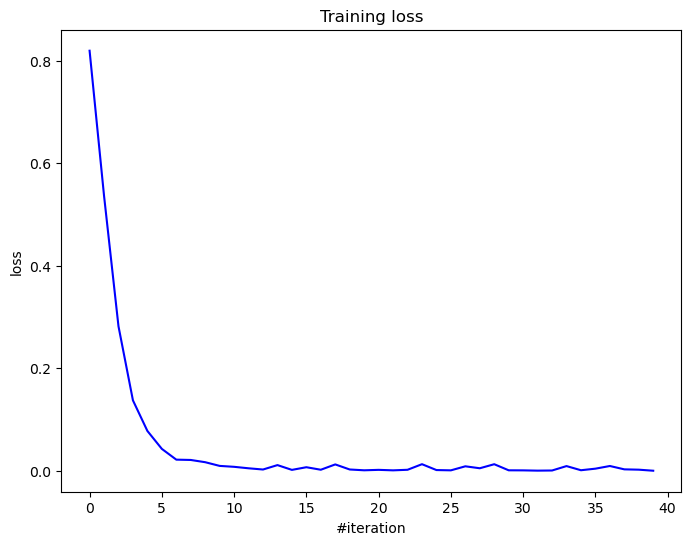

Current loss: 0.000326


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [8]:
output = net.forward(X)
predictions = np.argmax(output, axis=1)
true_labels = np.argmax(Y, axis=1)

# Вычисление точности
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 99.90%


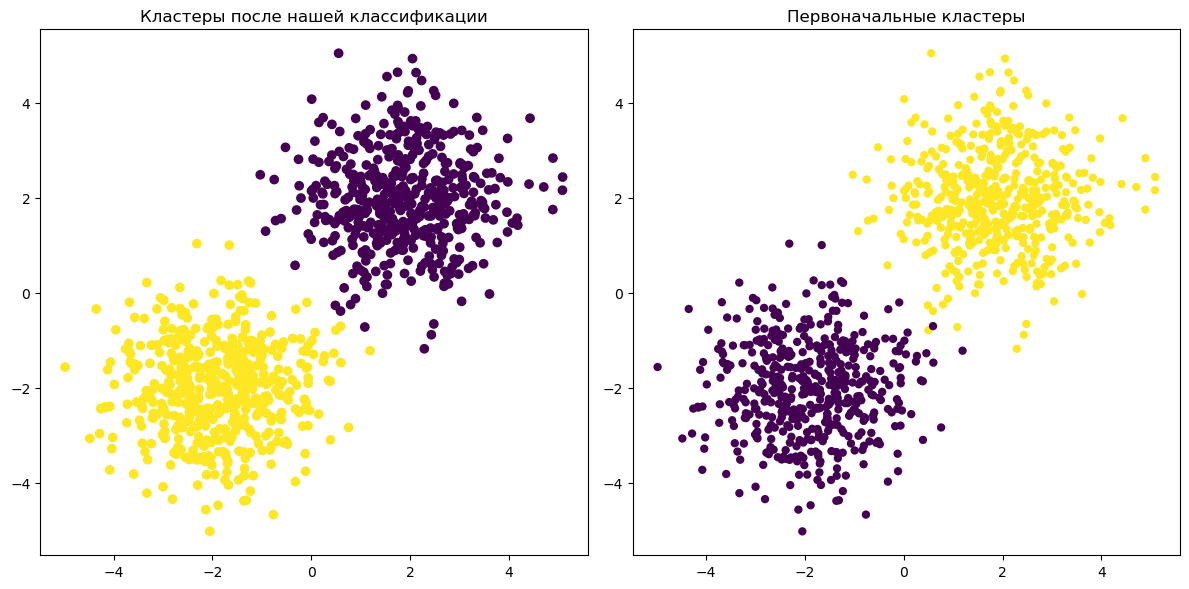

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Первый scatterplot
ax1.scatter(X[:, 0], X[:, 1], c=predictions)
ax1.set_title("Кластеры после нашей классификации")


# Второй scatterplot
ax2.scatter(X[:, 0], X[:, 1], c = Y[:,0], edgecolors='none')
ax2.set_title("Первоначальные кластеры")


# Отображаем графики
plt.tight_layout()
plt.show()

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [10]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [11]:
import numpy as np
import struct
from array import array


def read_images_labels(images_filepath, labels_filepath):        
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())        
    
    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())        
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img            
    
    return images, labels
    

In [12]:
train_images, train_labels = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_images, test_labels = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

val_size = 10000 

X_train, X_val = train_images[:-val_size], train_images[-val_size:]
y_train, y_val = train_labels[:-val_size], train_labels[-val_size:]


X_test, y_test = test_images, test_labels


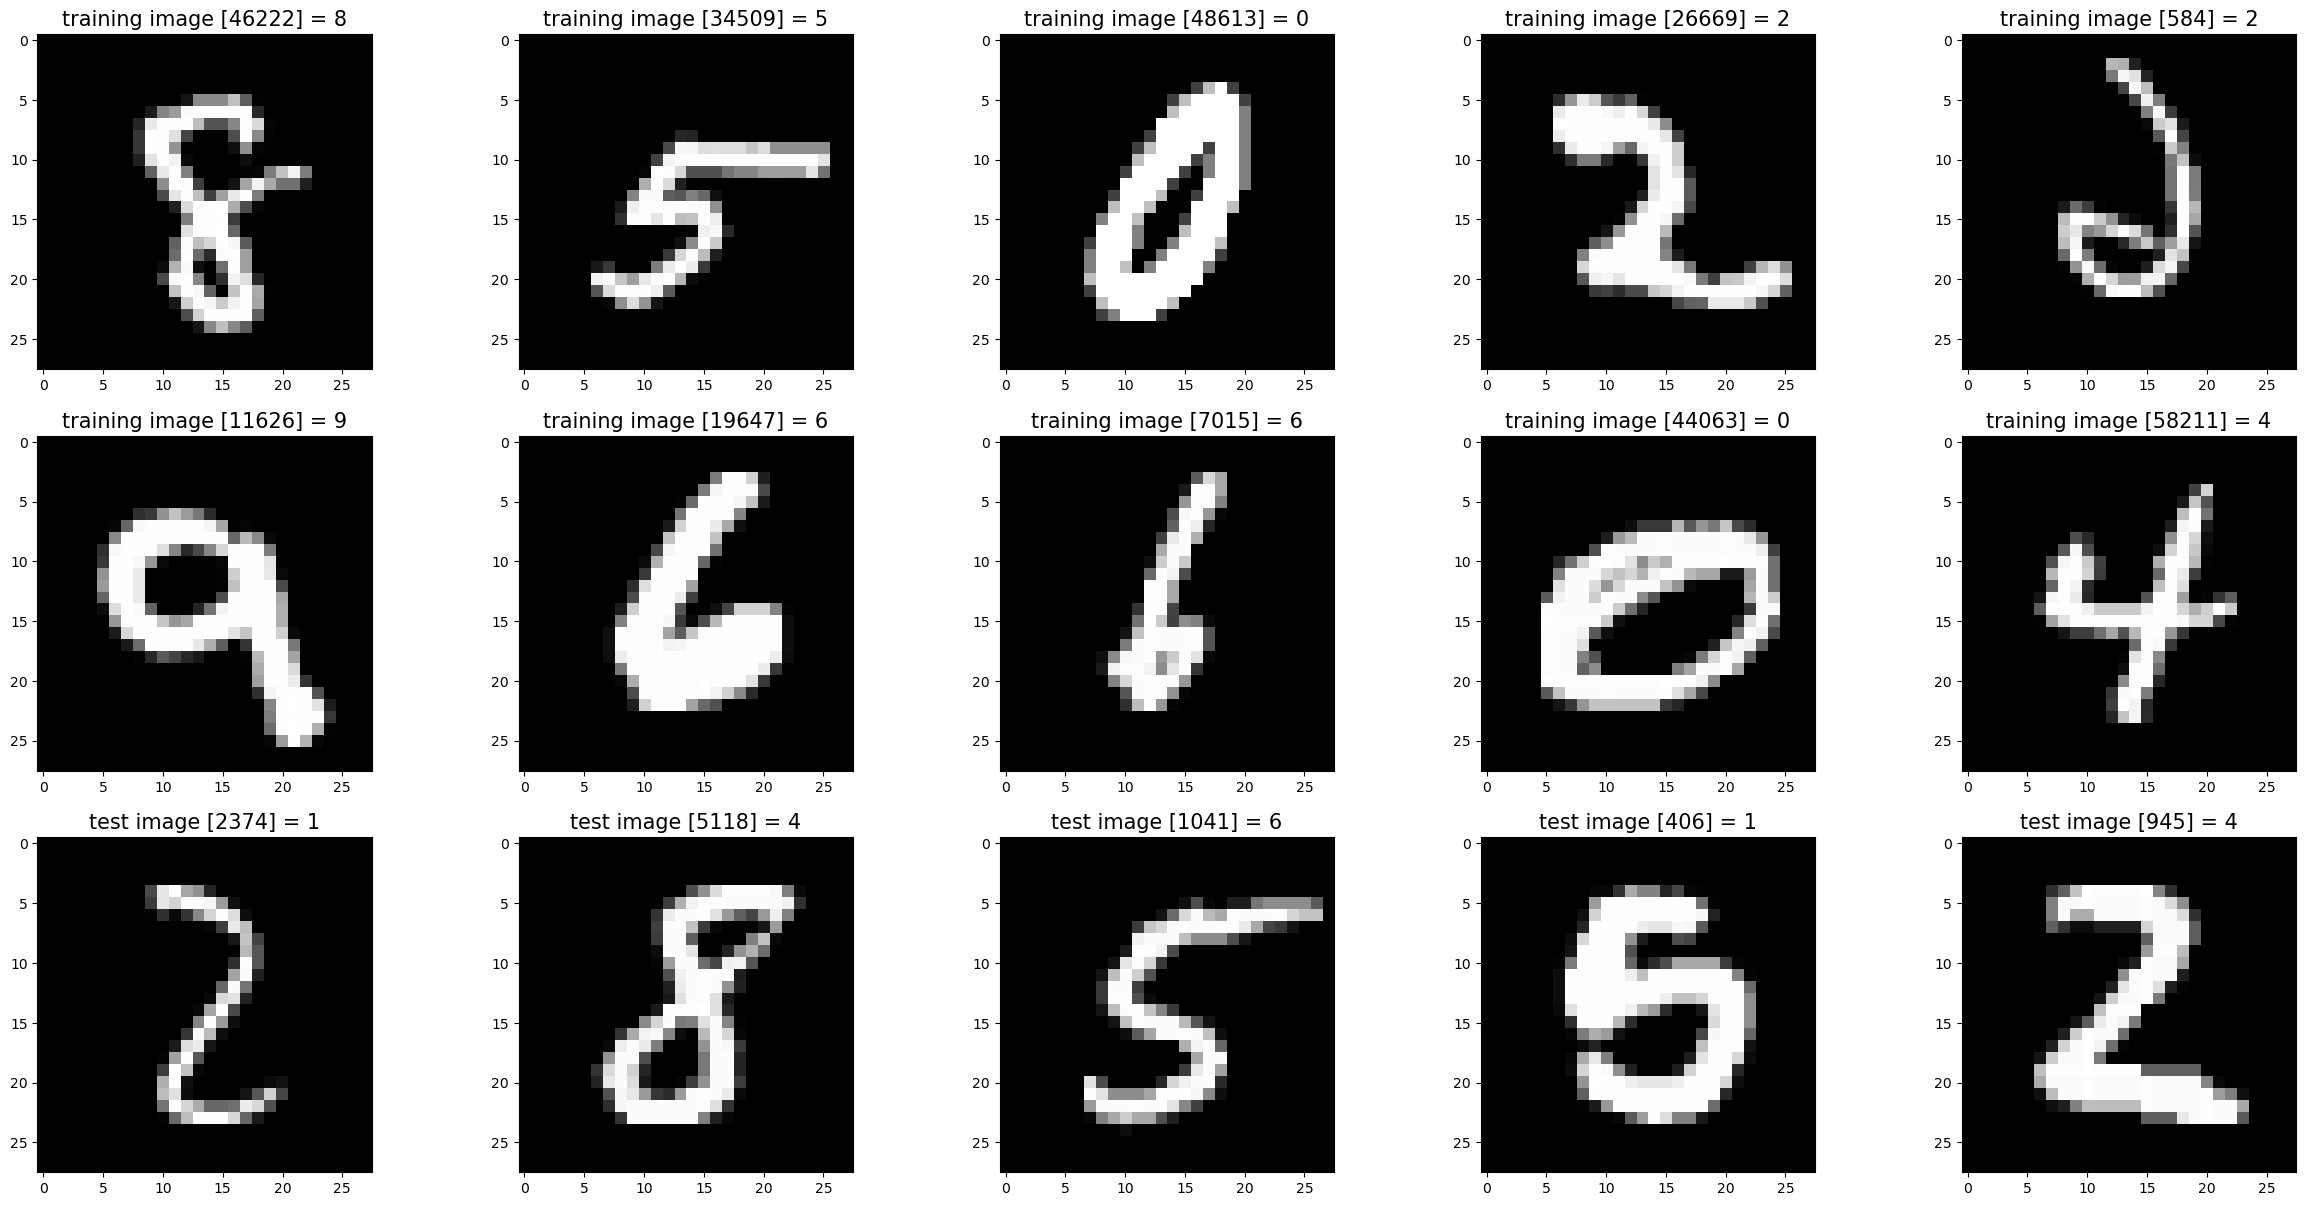

In [13]:
#
# Verify Reading Dataset via MnistDataloader class
#
import random
import matplotlib.pyplot as plt

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(train_images[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(train_labels[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(test_images[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(train_labels[r]))    

show_images(images_2_show, titles_2_show)

One-hot encode the labels first.

In [14]:
# Your code goes here. ################################################

X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)


def one_hot(labels, num_classes=10):
    ohe = np.zeros((labels.size, num_classes))
    ohe[np.arange(labels.size), labels] = 1
    return ohe



y_train = one_hot(y_train)
y_val = one_hot(y_val)
y_test = one_hot(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [15]:
# Модель с активацией ReLU
model_relu = Sequential()
model_relu.add(Flatten())
model_relu.add(Linear(784, 100))
model_relu.add(ReLU())
model_relu.add(Linear(100, 10))
model_relu.add(LogSoftMax())
print("Структура модели:  \n", model_relu)

Структура модели:  
 Flatten
Linear 784 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [16]:
# Модель с активацией ReLU для бача другого размера
model_relu3 = Sequential()
model_relu3.add(Flatten())
model_relu3.add(Linear(784, 100))
model_relu3.add(ReLU())
model_relu3.add(Linear(100, 10))
model_relu3.add(LogSoftMax())
print("Структура модели:  \n", model_relu3)

Структура модели:  
 Flatten
Linear 784 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [17]:
# Модель с активацией ReLU и BatchNorm
model_relu_bn = Sequential()
model_relu_bn.add(Flatten())
model_relu_bn.add(Linear(784, 100))
model_relu_bn.add(BatchNormalization())
model_relu_bn.add(ChannelwiseScaling(100))
model_relu_bn.add(ReLU())
model_relu_bn.add(Linear(100, 10))
model_relu_bn.add(LogSoftMax())
print("Структура модели:  \n", model_relu_bn)


Структура модели:  
 Flatten
Linear 784 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



In [18]:
# Модель с активацией ReLU и BatchNorm для другого размера бача
model_relu_bn1 = Sequential()
model_relu_bn1.add(Flatten())
model_relu_bn1.add(Linear(784, 100))
model_relu_bn1.add(BatchNormalization())
model_relu_bn1.add(ChannelwiseScaling(100))
model_relu_bn1.add(ReLU())
model_relu_bn1.add(Linear(100, 10))
model_relu_bn1.add(LogSoftMax())
print("Структура модели:  \n", model_relu_bn1)

Структура модели:  
 Flatten
Linear 784 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



In [19]:
# Модель с активацией ELU с альфа 1
model_elu = Sequential()
model_elu.add(Flatten())
model_elu.add(Linear(784, 100))
model_elu.add(ELU(alpha=1))
model_elu.add(Linear(100, 10))
model_elu.add(LogSoftMax())
print("Структура модели:  \n", model_elu)


Структура модели:  
 Flatten
Linear 784 -> 100
ELU
Linear 100 -> 10
LogSoftMax



In [20]:
# Модель с активацией ELU с альфа 0.5
model_elu1 = Sequential()
model_elu1.add(Flatten())
model_elu1.add(Linear(784, 100))
model_elu1.add(ELU(alpha=0.5))
model_elu1.add(Linear(100, 10))
model_elu1.add(LogSoftMax())
print("Структура модели:  \n", model_elu1)

Структура модели:  
 Flatten
Linear 784 -> 100
ELU
Linear 100 -> 10
LogSoftMax



In [21]:
# Модель с активацией LeakyReLU
model_leaky = Sequential()
model_leaky.add(Flatten())
model_leaky.add(Linear(784, 100))
model_leaky.add(LeakyReLU())
model_leaky.add(Linear(100, 10))
model_leaky.add(LogSoftMax())
print("Структура модели:  \n", model_leaky)

Структура модели:  
 Flatten
Linear 784 -> 100
LeakyReLU
Linear 100 -> 10
LogSoftMax



In [22]:
# Модель с активацией SoftPlus
model_softplus = Sequential()
model_softplus.add(Flatten())
model_softplus.add(Linear(784, 100))
model_softplus.add(SoftPlus())
model_softplus.add(Linear(100, 10))
model_softplus.add(LogSoftMax())
print("Структура модели: \n",model_softplus)

Структура модели: 
 Flatten
Linear 784 -> 100
SoftPlus
Linear 100 -> 10
LogSoftMax



In [23]:
# Модель с активацией ReLU Dropout BatchNorm
model_relu_final = Sequential()
model_relu_final.add(Flatten())
model_relu_final.add(Linear(784, 392))
model_relu_final.add(BatchNormalization())
model_relu_final.add(ChannelwiseScaling(392))
model_relu_final.add(ReLU())  

model_relu_final.add(Linear(392, 392))
model_relu_final.add(BatchNormalization())
model_relu_final.add(ChannelwiseScaling(392))
model_relu_final.add(ReLU()) 

model_relu_final.add(Dropout(0.5))
model_relu_final.add(Linear(392, 100))
model_relu_final.add(BatchNormalization())
model_relu_final.add(ChannelwiseScaling(100))
model_relu_final.add(ReLU())

model_relu_final.add(Linear(100, 10))
model_relu_final.add(LogSoftMax())
print("Структура модели:  \n", model_relu_final)

Структура модели:  
 Flatten
Linear 784 -> 392
BatchNormalization
ChannelwiseScaling
ReLU
Linear 392 -> 392
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 392 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



In [24]:
# Еще модель с активацией ReLU Dropout BatchNorm с другими линейными слоями

model_relu_final1 = Sequential()
model_relu_final1.add(Flatten())
model_relu_final1.add(Linear(784, 256))
model_relu_final1.add(BatchNormalization())
model_relu_final1.add(ChannelwiseScaling(256))
model_relu_final1.add(ReLU())  

model_relu_final1.add(Dropout(0.5))
model_relu_final1.add(Linear(256, 128))
model_relu_final1.add(BatchNormalization())
model_relu_final1.add(ChannelwiseScaling(128))
model_relu_final1.add(ReLU())  

model_relu_final1.add(Dropout(0.5))
model_relu_final1.add(Linear(128, 64))
model_relu_final1.add(BatchNormalization())
model_relu_final1.add(ChannelwiseScaling(64))
model_relu_final1.add(ReLU())

model_relu_final1.add(Linear(64, 10))
model_relu_final1.add(LogSoftMax())
print("Структура модели:  \n", model_relu_final1)

Структура модели:  
 Flatten
Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 128 -> 64
BatchNormalization
ChannelwiseScaling
ReLU
Linear 64 -> 10
LogSoftMax



In [25]:
# Еще модель с активацией ReLU Dropout BatchNorm с большим количеством слоев
model_relu_final2 = Sequential()

model_relu_final2.add(Flatten())

model_relu_final2.add(Linear(784, 512))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(512))
model_relu_final2.add(ReLU())

model_relu_final2.add(Dropout(0.2))  # Меньший dropout в начале
model_relu_final2.add(Linear(512, 512))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(512))
model_relu_final2.add(ReLU())

model_relu_final2.add(Dropout(0.3))
model_relu_final2.add(Linear(512, 256))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(256))
model_relu_final2.add(ReLU())

model_relu_final2.add(Dropout(0.4))
model_relu_final2.add(Linear(256, 128))
model_relu_final2.add(BatchNormalization())
model_relu_final2.add(ChannelwiseScaling(128))
model_relu_final2.add(ReLU())

model_relu_final2.add(Dropout(0.5))
model_relu_final2.add(Linear(128, 10))
model_relu_final2.add(LogSoftMax())

print("Структура модели:  \n", model_relu_final2)

Структура модели:  
 Flatten
Linear 784 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 512 -> 512
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 512 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 128 -> 10
LogSoftMax



In [26]:
# Модель с активацией ReLU для другого оптимизатора
model_relu2 = Sequential()
model_relu2.add(Flatten())
model_relu2.add(Linear(784, 100))
model_relu2.add(ReLU())  
model_relu2.add(Linear(100, 10))
model_relu2.add(LogSoftMax())
print("Структура модели:  \n", model_relu2)


Структура модели:  
 Flatten
Linear 784 -> 100
ReLU
Linear 100 -> 10
LogSoftMax



In [27]:
def train_mnist(train_x, train_y, val_x, val_y, test_x, test_y, model, n_epoch=10, batch_size=128, learning_rate=1e-1, beta1=0.9, beta2=0.999, EPS=1e-8, lr_decay=1):
    """
    Обучает классификатор для MNIST. train_y и test_y уже в one-hot формате.

    Args:
        train_x: тренировочные данные (изображения).
        train_y: тренировочные метки (one-hot).
        val_x: валидационные данные (изображения).
        val_y: валидационные метки (one-hot).
        test_x: тестовые данные (изображения).
        test_y: тестовые метки (one-hot).
        n_epoch: количество эпох обучения.
        batch_size: размер батча.
        learning_rate: скорость обучения.
        beta1: beta1 для Adam оптимизатора.
        beta2: beta2 для Adam оптимизатора.
        EPS: малое значение для предотвращения деления на ноль.

    Returns:
        Sequential: обученный классификатор.
        test_losses: список значений потерь на валидационной выборке.
        test_accuracies: список значений точности на валидации выборке.
    """

    # 2. Создаем критерий
    criterion = ClassNLLCriterion()

    # 3. Настраиваем оптимизатор
    optimizer_config = {
        'learning_rate': learning_rate,
        'beta1': beta1,
        'beta2': beta2,
        'epsilon': EPS
    }
    optimizer_state = {}

    # Для хранения метрик обучения
    val_losses = []
    val_accuracies = []


    # 4. Обучаем модель
    for epoch in range(n_epoch):
        model.train()

        # Изменяем скорость обучения каждые 6 эпох
        if lr_decay != 1:
            if (epoch + 1) % 6 == 0:
                optimizer_config['learning_rate'] *= lr_decay
                print(f"Learning rate decreased to {optimizer_config['learning_rate']}")
        for x_batch, y_batch_onehot in get_batches((train_x, train_y), batch_size):
            # Прямой проход
            predictions = model.forward(x_batch)

            # Вычисляем потери
            loss = criterion.forward(predictions, y_batch_onehot)

            # Обратный проход
            grad_output = criterion.backward(predictions, y_batch_onehot)
            model.backward(x_batch, grad_output)

            # Обновляем параметры модели
            adam_optimizer(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
            model.zeroGradParameters()

        # Вычисляем потери и точность на тестовой выборке
        model.evaluate()
        val_predictions = model.forward(val_x)
        val_loss = criterion.forward(val_predictions, val_y)
        accuracy = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(val_y, axis=1))
    
        # Сохраняем метрики
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{n_epoch}, Val loss: {val_loss:.4f}, Val acc : {accuracy:.4f}")

    # model.evaluate()
    
    test_predictions = model.forward(test_x)
    test_loss = criterion.forward(val_predictions, val_y)
    test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))
    print("\nПроверяем модель на тестовой выборке : ")
    print(f"Test loss: {test_loss:.4f}, Test acc : {test_accuracy:.4f}")

    return model, val_losses, val_accuracies, test_loss, test_accuracy

In [28]:
def train_mnist_sgd(train_x, train_y, val_x, val_y, test_x, test_y, model, n_epoch=10, batch_size=128, learning_rate=1e-1, momentum=0.9):
    """
    Обучает классификатор для MNIST. train_y и test_y уже в one-hot формате.

    Args:
        train_x: тренировочные данные (изображения).
        train_y: тренировочные метки (one-hot).
        val_x: валидационные данные (изображения).
        val_y: валидационные метки (one-hot).
        test_x: тестовые данные (изображения).
        test_y: тестовые метки (one-hot).
        n_epoch: количество эпох обучения.
        batch_size: размер батча.
        learning_rate: скорость обучения.
        momentum: параметр для SDG оптимизатора


    Returns:
        Sequential: обученный классификатор.
        test_losses: список значений потерь на тестовой выборке.
        test_accuracies: список значений точности на тестовой выборке.
    """

    # 2. Создаем критерий
    criterion = ClassNLLCriterion()

    # 3. Настраиваем оптимизатор
    optimizer_config = {
        'learning_rate': learning_rate,
        'momentum': momentum,
    }
    optimizer_state = {}

    # Для хранения метрик обучения
    val_losses = []
    val_accuracies = []

    # 4. Обучаем модель
    for epoch in range(n_epoch):
        model.train()
        for x_batch, y_batch_onehot in get_batches((train_x, train_y), batch_size):
            # Прямой проход
            predictions = model.forward(x_batch)

            # Вычисляем потери
            loss = criterion.forward(predictions, y_batch_onehot)

            # Обратный проход
            grad_output = criterion.backward(predictions, y_batch_onehot)
            model.backward(x_batch, grad_output)

            # Обновляем параметры модели
            sgd_momentum(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
            model.zeroGradParameters()

        # Вычисляем потери и точность на тестовой выборке
        model.evaluate()
        val_predictions = model.forward(val_x)
        val_loss = criterion.forward(val_predictions, val_y)
        accuracy = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(val_y, axis=1))
    
        # Сохраняем метрики
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{n_epoch}, Val loss: {val_loss:.4f}, Val acc : {accuracy:.4f}")

    # model.evaluate()
    
    test_predictions = model.forward(test_x)
    test_loss = criterion.forward(test_predictions, test_y)
    test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))
    print("\nПроверяем модель на тестовой выборке : ")
    print(f"Test loss: {test_loss:.4f}, Test acc : {test_accuracy:.4f}")

    return model, val_losses, val_accuracies, test_loss, test_accuracy

In [29]:
n_epoch = 25
batch_size = 2500
lr = 3e-3

In [30]:
print('Обучение модели с активацией ReLU с помощью Adam optimazier')
trained_model_relu, val_losses_relu, val_accuracies_relu, loss_relu, acc_relu = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_relu, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ReLU с помощью Adam optimazier
Epoch 1/25, Val loss: 0.4231, Val acc : 0.8836
Epoch 2/25, Val loss: 0.3027, Val acc : 0.9157
Epoch 3/25, Val loss: 0.2672, Val acc : 0.9247
Epoch 4/25, Val loss: 0.2456, Val acc : 0.9305
Epoch 5/25, Val loss: 0.2288, Val acc : 0.9356
Epoch 6/25, Val loss: 0.2127, Val acc : 0.9414
Epoch 7/25, Val loss: 0.1966, Val acc : 0.9452
Epoch 8/25, Val loss: 0.1827, Val acc : 0.9500
Epoch 9/25, Val loss: 0.1734, Val acc : 0.9518
Epoch 10/25, Val loss: 0.1603, Val acc : 0.9555
Epoch 11/25, Val loss: 0.1517, Val acc : 0.9576
Epoch 12/25, Val loss: 0.1440, Val acc : 0.9594
Epoch 13/25, Val loss: 0.1369, Val acc : 0.9618
Epoch 14/25, Val loss: 0.1302, Val acc : 0.9639
Epoch 15/25, Val loss: 0.1252, Val acc : 0.9647
Epoch 16/25, Val loss: 0.1221, Val acc : 0.9654
Epoch 17/25, Val loss: 0.1171, Val acc : 0.9660
Epoch 18/25, Val loss: 0.1153, Val acc : 0.9660
Epoch 19/25, Val loss: 0.1104, Val acc : 0.9673
Epoch 20/25, Val loss: 0.1082, Val ac

In [31]:
# test_predictions = trained_model_relu.forward(X_test)
# test_loss = criterion.forward(test_predictions, y_test)
# accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(test_y, axis=1))

In [32]:
print('Обучение модели с активацией ReLU с помощью Adam optimazier 500')
trained_model_relu3, val_losses_relu3, val_accuracies_relu3, loss_relu3, acc_relu3 = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_relu3, n_epoch=n_epoch, batch_size=500, learning_rate=lr)

Обучение модели с активацией ReLU с помощью Adam optimazier 500
Epoch 1/25, Val loss: 0.2541, Val acc : 0.9265
Epoch 2/25, Val loss: 0.1840, Val acc : 0.9493
Epoch 3/25, Val loss: 0.1530, Val acc : 0.9570
Epoch 4/25, Val loss: 0.1290, Val acc : 0.9634
Epoch 5/25, Val loss: 0.1127, Val acc : 0.9660
Epoch 6/25, Val loss: 0.1054, Val acc : 0.9698
Epoch 7/25, Val loss: 0.1054, Val acc : 0.9673
Epoch 8/25, Val loss: 0.0972, Val acc : 0.9712
Epoch 9/25, Val loss: 0.1007, Val acc : 0.9699
Epoch 10/25, Val loss: 0.0880, Val acc : 0.9738
Epoch 11/25, Val loss: 0.0921, Val acc : 0.9730
Epoch 12/25, Val loss: 0.0918, Val acc : 0.9739
Epoch 13/25, Val loss: 0.0863, Val acc : 0.9749
Epoch 14/25, Val loss: 0.0884, Val acc : 0.9750
Epoch 15/25, Val loss: 0.0884, Val acc : 0.9757
Epoch 16/25, Val loss: 0.0910, Val acc : 0.9742
Epoch 17/25, Val loss: 0.0871, Val acc : 0.9754
Epoch 18/25, Val loss: 0.0910, Val acc : 0.9767
Epoch 19/25, Val loss: 0.0869, Val acc : 0.9765
Epoch 20/25, Val loss: 0.0921, Va

In [33]:
print('Обучение модели с активацией ReLU и BatchNormalization')
trained_model_relu_bn, val_losses_relu_bn, val_accuracies_relu_bn, loss_relu_bn, acc_relu_bn = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test,model_relu_bn, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ReLU и BatchNormalization
Epoch 1/25, Val loss: 1.8281, Val acc : 0.7719
Epoch 2/25, Val loss: 1.0950, Val acc : 0.8579
Epoch 3/25, Val loss: 0.5825, Val acc : 0.9040
Epoch 4/25, Val loss: 0.3877, Val acc : 0.9146
Epoch 5/25, Val loss: 0.3177, Val acc : 0.9238
Epoch 6/25, Val loss: 0.2790, Val acc : 0.9309
Epoch 7/25, Val loss: 0.2580, Val acc : 0.9352
Epoch 8/25, Val loss: 0.2383, Val acc : 0.9400
Epoch 9/25, Val loss: 0.2224, Val acc : 0.9435
Epoch 10/25, Val loss: 0.2077, Val acc : 0.9472
Epoch 11/25, Val loss: 0.1949, Val acc : 0.9489
Epoch 12/25, Val loss: 0.1838, Val acc : 0.9545
Epoch 13/25, Val loss: 0.1771, Val acc : 0.9531
Epoch 14/25, Val loss: 0.1698, Val acc : 0.9547
Epoch 15/25, Val loss: 0.1610, Val acc : 0.9566
Epoch 16/25, Val loss: 0.1552, Val acc : 0.9587
Epoch 17/25, Val loss: 0.1490, Val acc : 0.9611
Epoch 18/25, Val loss: 0.1437, Val acc : 0.9610
Epoch 19/25, Val loss: 0.1422, Val acc : 0.9625
Epoch 20/25, Val loss: 0.1379, Val acc : 0

In [34]:
print('Обучение модели с активацией ReLU и BatchNormalization batchsize 500')
trained_model_relu_bn1, val_losses_relu_bn1, val_accuracies_relu_bn1, loss_relu_bn1, acc_relu_bn1 = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test,model_relu_bn1, n_epoch=n_epoch, batch_size=500, learning_rate=lr)

Обучение модели с активацией ReLU и BatchNormalization batchsize 500
Epoch 1/25, Val loss: 0.3289, Val acc : 0.9186
Epoch 2/25, Val loss: 0.2294, Val acc : 0.9360
Epoch 3/25, Val loss: 0.1810, Val acc : 0.9518
Epoch 4/25, Val loss: 0.1487, Val acc : 0.9586
Epoch 5/25, Val loss: 0.1281, Val acc : 0.9650
Epoch 6/25, Val loss: 0.1272, Val acc : 0.9645
Epoch 7/25, Val loss: 0.1076, Val acc : 0.9702
Epoch 8/25, Val loss: 0.1059, Val acc : 0.9683
Epoch 9/25, Val loss: 0.0991, Val acc : 0.9712
Epoch 10/25, Val loss: 0.1037, Val acc : 0.9677
Epoch 11/25, Val loss: 0.0957, Val acc : 0.9707
Epoch 12/25, Val loss: 0.0945, Val acc : 0.9725
Epoch 13/25, Val loss: 0.0993, Val acc : 0.9704
Epoch 14/25, Val loss: 0.0943, Val acc : 0.9724
Epoch 15/25, Val loss: 0.0926, Val acc : 0.9735
Epoch 16/25, Val loss: 0.0968, Val acc : 0.9717
Epoch 17/25, Val loss: 0.0926, Val acc : 0.9738
Epoch 18/25, Val loss: 0.0978, Val acc : 0.9727
Epoch 19/25, Val loss: 0.0958, Val acc : 0.9740
Epoch 20/25, Val loss: 0.094

In [35]:
print('Обучение модели с активацией ELU')
trained_model_elu, val_losses_elu, val_accuracies_elu, loss_elu, acc_elu = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_elu, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ELU
Epoch 1/25, Val loss: 0.3963, Val acc : 0.8861
Epoch 2/25, Val loss: 0.3017, Val acc : 0.9143
Epoch 3/25, Val loss: 0.2711, Val acc : 0.9227
Epoch 4/25, Val loss: 0.2539, Val acc : 0.9284
Epoch 5/25, Val loss: 0.2360, Val acc : 0.9344
Epoch 6/25, Val loss: 0.2181, Val acc : 0.9404
Epoch 7/25, Val loss: 0.2031, Val acc : 0.9465
Epoch 8/25, Val loss: 0.1908, Val acc : 0.9478
Epoch 9/25, Val loss: 0.1777, Val acc : 0.9515
Epoch 10/25, Val loss: 0.1652, Val acc : 0.9551
Epoch 11/25, Val loss: 0.1548, Val acc : 0.9577
Epoch 12/25, Val loss: 0.1467, Val acc : 0.9585
Epoch 13/25, Val loss: 0.1429, Val acc : 0.9601
Epoch 14/25, Val loss: 0.1354, Val acc : 0.9621
Epoch 15/25, Val loss: 0.1280, Val acc : 0.9643
Epoch 16/25, Val loss: 0.1225, Val acc : 0.9652
Epoch 17/25, Val loss: 0.1172, Val acc : 0.9666
Epoch 18/25, Val loss: 0.1130, Val acc : 0.9670
Epoch 19/25, Val loss: 0.1102, Val acc : 0.9682
Epoch 20/25, Val loss: 0.1063, Val acc : 0.9690
Epoch 21/25, Val

In [36]:
print('Обучение модели с активацией ELU с другим alpha')
# trained_model_elu1, test_losses_elu1, test_accuracies_elu1 = train_mnist(X_train, y_train, X_val, y_val, model_elu1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)
trained_model_elu1, val_losses_elu1, val_accuracies_elu1, loss_elu1, acc_elu1 = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_elu1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ELU с другим alpha
Epoch 1/25, Val loss: 0.4040, Val acc : 0.8837
Epoch 2/25, Val loss: 0.3014, Val acc : 0.9163
Epoch 3/25, Val loss: 0.2727, Val acc : 0.9228
Epoch 4/25, Val loss: 0.2566, Val acc : 0.9290
Epoch 5/25, Val loss: 0.2370, Val acc : 0.9334
Epoch 6/25, Val loss: 0.2217, Val acc : 0.9400
Epoch 7/25, Val loss: 0.2063, Val acc : 0.9438
Epoch 8/25, Val loss: 0.1919, Val acc : 0.9480
Epoch 9/25, Val loss: 0.1813, Val acc : 0.9507
Epoch 10/25, Val loss: 0.1675, Val acc : 0.9542
Epoch 11/25, Val loss: 0.1625, Val acc : 0.9565
Epoch 12/25, Val loss: 0.1508, Val acc : 0.9583
Epoch 13/25, Val loss: 0.1446, Val acc : 0.9604
Epoch 14/25, Val loss: 0.1390, Val acc : 0.9622
Epoch 15/25, Val loss: 0.1346, Val acc : 0.9621
Epoch 16/25, Val loss: 0.1294, Val acc : 0.9631
Epoch 17/25, Val loss: 0.1232, Val acc : 0.9638
Epoch 18/25, Val loss: 0.1190, Val acc : 0.9658
Epoch 19/25, Val loss: 0.1156, Val acc : 0.9659
Epoch 20/25, Val loss: 0.1125, Val acc : 0.9665
E

In [37]:
print('Обучение модели с активацией LeakyReLU')
# trained_model_leaky, test_losses_leaky, test_accuracies_leaky = train_mnist(X_train, y_train, X_val, y_val,model_leaky, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)
trained_model_leaky, val_losses_leaky, val_accuracies_leaky, loss_leaky, acc_leaky = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_leaky, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией LeakyReLU
Epoch 1/25, Val loss: 0.4137, Val acc : 0.8835
Epoch 2/25, Val loss: 0.2976, Val acc : 0.9166
Epoch 3/25, Val loss: 0.2652, Val acc : 0.9226
Epoch 4/25, Val loss: 0.2363, Val acc : 0.9331
Epoch 5/25, Val loss: 0.2165, Val acc : 0.9398
Epoch 6/25, Val loss: 0.1994, Val acc : 0.9449
Epoch 7/25, Val loss: 0.1870, Val acc : 0.9491
Epoch 8/25, Val loss: 0.1740, Val acc : 0.9529
Epoch 9/25, Val loss: 0.1643, Val acc : 0.9545
Epoch 10/25, Val loss: 0.1547, Val acc : 0.9568
Epoch 11/25, Val loss: 0.1461, Val acc : 0.9581
Epoch 12/25, Val loss: 0.1407, Val acc : 0.9608
Epoch 13/25, Val loss: 0.1330, Val acc : 0.9621
Epoch 14/25, Val loss: 0.1262, Val acc : 0.9639
Epoch 15/25, Val loss: 0.1237, Val acc : 0.9651
Epoch 16/25, Val loss: 0.1199, Val acc : 0.9643
Epoch 17/25, Val loss: 0.1141, Val acc : 0.9667
Epoch 18/25, Val loss: 0.1100, Val acc : 0.9685
Epoch 19/25, Val loss: 0.1086, Val acc : 0.9687
Epoch 20/25, Val loss: 0.1055, Val acc : 0.9683
Epoch 21/2

In [38]:
print('Обучение модели с активацией SoftPlus')
# trained_model_softplus, test_losses_softplus, test_accuracies_softplus = train_mnist(X_train, y_train, X_val, y_val,model_softplus, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)
trained_model_softplus, val_losses_softplus, val_accuracies_softplus, loss_softplus, acc_softplus = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_softplus, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией SoftPlus
Epoch 1/25, Val loss: 0.5574, Val acc : 0.8516
Epoch 2/25, Val loss: 0.3431, Val acc : 0.9048
Epoch 3/25, Val loss: 0.2918, Val acc : 0.9181
Epoch 4/25, Val loss: 0.2651, Val acc : 0.9267
Epoch 5/25, Val loss: 0.2429, Val acc : 0.9324
Epoch 6/25, Val loss: 0.2338, Val acc : 0.9353
Epoch 7/25, Val loss: 0.2157, Val acc : 0.9419
Epoch 8/25, Val loss: 0.2050, Val acc : 0.9435
Epoch 9/25, Val loss: 0.1920, Val acc : 0.9487
Epoch 10/25, Val loss: 0.1835, Val acc : 0.9501
Epoch 11/25, Val loss: 0.1734, Val acc : 0.9539
Epoch 12/25, Val loss: 0.1697, Val acc : 0.9527
Epoch 13/25, Val loss: 0.1616, Val acc : 0.9561
Epoch 14/25, Val loss: 0.1536, Val acc : 0.9574
Epoch 15/25, Val loss: 0.1470, Val acc : 0.9590
Epoch 16/25, Val loss: 0.1440, Val acc : 0.9583
Epoch 17/25, Val loss: 0.1383, Val acc : 0.9605
Epoch 18/25, Val loss: 0.1350, Val acc : 0.9615
Epoch 19/25, Val loss: 0.1313, Val acc : 0.9633
Epoch 20/25, Val loss: 0.1265, Val acc : 0.9654
Epoch 21/25

In [39]:
print('Обучение модели с помощью SGD optimazier')
# trained_model_relu_sgd, test_losses_relu_sgd, test_accuracies_relu_sgd = train_mnist_sgd(X_train, y_train, X_val, y_val,model_relu2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

trained_model_sgd, val_losses_sgd, val_accuracies_sgd, loss_sgd, acc_sgd = train_mnist_sgd(X_train, y_train, X_val, y_val, X_test, y_test, model_relu2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с помощью SGD optimazier
Epoch 1/25, Val loss: 2.2442, Val acc : 0.3123
Epoch 2/25, Val loss: 2.1395, Val acc : 0.5665
Epoch 3/25, Val loss: 2.0019, Val acc : 0.6705
Epoch 4/25, Val loss: 1.8334, Val acc : 0.7210
Epoch 5/25, Val loss: 1.6424, Val acc : 0.7581
Epoch 6/25, Val loss: 1.4440, Val acc : 0.7845
Epoch 7/25, Val loss: 1.2577, Val acc : 0.8055
Epoch 8/25, Val loss: 1.0981, Val acc : 0.8226
Epoch 9/25, Val loss: 0.9695, Val acc : 0.8345
Epoch 10/25, Val loss: 0.8688, Val acc : 0.8434
Epoch 11/25, Val loss: 0.7903, Val acc : 0.8492
Epoch 12/25, Val loss: 0.7280, Val acc : 0.8539
Epoch 13/25, Val loss: 0.6782, Val acc : 0.8597
Epoch 14/25, Val loss: 0.6374, Val acc : 0.8640
Epoch 15/25, Val loss: 0.6035, Val acc : 0.8694
Epoch 16/25, Val loss: 0.5750, Val acc : 0.8739
Epoch 17/25, Val loss: 0.5507, Val acc : 0.8767
Epoch 18/25, Val loss: 0.5298, Val acc : 0.8797
Epoch 19/25, Val loss: 0.5115, Val acc : 0.8805
Epoch 20/25, Val loss: 0.4956, Val acc : 0.8825
Epoch 21

In [40]:
print('Обучение модели с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом')
# trained_model_final, test_losses_final, test_accuracies_final = train_mnist(X_train, y_train, X_val, y_val, model_relu_final, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr, lr_decay=0.5)

trained_model_final, val_losses_final, val_accuracies_final, loss_final, acc_final = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_relu_final, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом
Epoch 1/25, Val loss: 1.7289, Val acc : 0.8794
Epoch 2/25, Val loss: 0.7785, Val acc : 0.9613
Epoch 3/25, Val loss: 0.2315, Val acc : 0.9747
Epoch 4/25, Val loss: 0.1061, Val acc : 0.9801
Epoch 5/25, Val loss: 0.0805, Val acc : 0.9803
Epoch 6/25, Val loss: 0.0683, Val acc : 0.9823
Epoch 7/25, Val loss: 0.0627, Val acc : 0.9828
Epoch 8/25, Val loss: 0.0598, Val acc : 0.9836
Epoch 9/25, Val loss: 0.0597, Val acc : 0.9846
Epoch 10/25, Val loss: 0.0596, Val acc : 0.9829
Epoch 11/25, Val loss: 0.0551, Val acc : 0.9850
Epoch 12/25, Val loss: 0.0579, Val acc : 0.9840
Epoch 13/25, Val loss: 0.0575, Val acc : 0.9834
Epoch 14/25, Val loss: 0.0561, Val acc : 0.9840
Epoch 15/25, Val loss: 0.0572, Val acc : 0.9845
Epoch 16/25, Val loss: 0.0568, Val acc : 0.9846
Epoch 17/25, Val loss: 0.0550, Val acc : 0.9846
Epoch 18/25, Val loss: 0.0563, Val acc : 0.9849
Epoch 19/25, Val loss: 0.0563, Val

In [41]:
print('Обучение модели 1 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом')
# trained_model_final1, test_losses_final1, test_accuracies_final1 = train_mnist(X_train, y_train, X_val, y_val, model_relu_final1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr, lr_decay=0.5)

trained_model_final1, val_losses_final1, val_accuracies_final1, loss_final1, acc_final1 = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_relu_final1, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели 1 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом
Epoch 1/25, Val loss: 1.9256, Val acc : 0.7676
Epoch 2/25, Val loss: 1.2446, Val acc : 0.9205
Epoch 3/25, Val loss: 0.5525, Val acc : 0.9572
Epoch 4/25, Val loss: 0.2259, Val acc : 0.9659
Epoch 5/25, Val loss: 0.1424, Val acc : 0.9708
Epoch 6/25, Val loss: 0.1110, Val acc : 0.9743
Epoch 7/25, Val loss: 0.0976, Val acc : 0.9741
Epoch 8/25, Val loss: 0.0893, Val acc : 0.9761
Epoch 9/25, Val loss: 0.0843, Val acc : 0.9762
Epoch 10/25, Val loss: 0.0802, Val acc : 0.9769
Epoch 11/25, Val loss: 0.0778, Val acc : 0.9778
Epoch 12/25, Val loss: 0.0787, Val acc : 0.9771
Epoch 13/25, Val loss: 0.0751, Val acc : 0.9796
Epoch 14/25, Val loss: 0.0747, Val acc : 0.9785
Epoch 15/25, Val loss: 0.0748, Val acc : 0.9776
Epoch 16/25, Val loss: 0.0735, Val acc : 0.9800
Epoch 17/25, Val loss: 0.0722, Val acc : 0.9804
Epoch 18/25, Val loss: 0.0703, Val acc : 0.9804
Epoch 19/25, Val loss: 0.0698, V

In [42]:
print('Обучение модели 2 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом')
# trained_model_final2, test_losses_final2, test_accuracies_final2 = train_mnist(X_train, y_train, X_val, y_val, model_relu_final2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr, lr_decay=0.5)

trained_model_final2, val_losses_final2, val_accuracies_final2, loss_final2, acc_final2 = train_mnist(X_train, y_train, X_val, y_val, X_test, y_test, model_relu_final2, n_epoch=n_epoch, batch_size=batch_size, learning_rate=lr)

Обучение модели 2 с активацией ReLU, BatchNormalization, Dropout с помощью Adam optimazier c уменьшающимся шагом
Epoch 1/25, Val loss: 1.7051, Val acc : 0.8201
Epoch 2/25, Val loss: 0.7213, Val acc : 0.9649
Epoch 3/25, Val loss: 0.1764, Val acc : 0.9765
Epoch 4/25, Val loss: 0.0875, Val acc : 0.9788
Epoch 5/25, Val loss: 0.0756, Val acc : 0.9806
Epoch 6/25, Val loss: 0.0745, Val acc : 0.9790
Epoch 7/25, Val loss: 0.0667, Val acc : 0.9820
Epoch 8/25, Val loss: 0.0693, Val acc : 0.9826
Epoch 9/25, Val loss: 0.0665, Val acc : 0.9820
Epoch 10/25, Val loss: 0.0662, Val acc : 0.9828
Epoch 11/25, Val loss: 0.0695, Val acc : 0.9825
Epoch 12/25, Val loss: 0.0661, Val acc : 0.9835
Epoch 13/25, Val loss: 0.0740, Val acc : 0.9818
Epoch 14/25, Val loss: 0.0692, Val acc : 0.9823
Epoch 15/25, Val loss: 0.0687, Val acc : 0.9833
Epoch 16/25, Val loss: 0.0785, Val acc : 0.9813
Epoch 17/25, Val loss: 0.0760, Val acc : 0.9822
Epoch 18/25, Val loss: 0.0715, Val acc : 0.9833
Epoch 19/25, Val loss: 0.0790, V

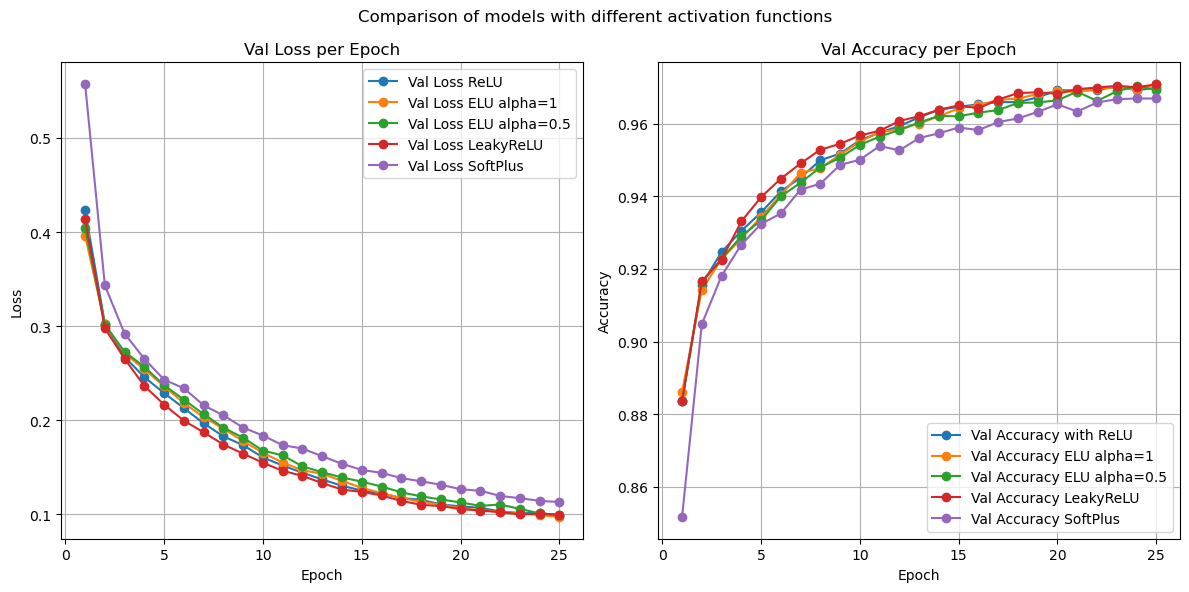

In [43]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_losses_relu) + 1), val_losses_relu, marker='o', label='Val Loss ReLU')
# plt.plot(range(1, len(test_losses_relu_bn) + 1), test_losses_relu_bn, marker='o', label='Test Loss with ReLU and BatchNorm')
plt.plot(range(1, len(val_losses_elu) + 1), val_losses_elu, marker='o', label='Val Loss ELU alpha=1')
plt.plot(range(1, len(val_losses_elu1) + 1), val_losses_elu1, marker='o', label='Val Loss ELU alpha=0.5')
plt.plot(range(1, len(val_losses_leaky) + 1), val_losses_leaky, marker='o', label='Val Loss LeakyReLU')
plt.plot(range(1, len(val_losses_softplus) + 1), val_losses_softplus, marker='o', label='Val Loss SoftPlus')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_relu) + 1), val_accuracies_relu, marker='o',  label='Val Accuracy with ReLU')
# plt.plot(range(1, len(test_accuracies_relu_bn) + 1), test_accuracies_relu_bn, marker='o',  label='Test Accuracy with ReLU and BatchNorm')
plt.plot(range(1, len(val_accuracies_elu) + 1), val_accuracies_elu, marker='o',  label='Val Accuracy ELU alpha=1')
plt.plot(range(1, len(val_accuracies_elu1) + 1), val_accuracies_elu1, marker='o',  label='Val Accuracy ELU alpha=0.5')
plt.plot(range(1, len(val_accuracies_leaky) + 1), val_accuracies_leaky, marker='o',  label='Val Accuracy LeakyReLU')
plt.plot(range(1, len(val_accuracies_softplus) + 1), val_accuracies_softplus, marker='o', label='Val Accuracy SoftPlus')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of models with different activation functions')
plt.tight_layout()

plt.show()

**Функции активации:**
* Видно, что различные функции активации влияют на скорость сходимости, например SoftPlus и ELU дают меньшую скорость сходимости по сравнению с ReLU и LeakyReLU
* SoftPlus и ELU более сложные в вычислениях, хотя получаемая кривая обучения получается более гладкая нежели с ReLU или LeakyReLU
* Считается что ELU обладает более высокой скоростью сходимости, но в данном случае получаем противоположный результат. При изменении альфа, в данном случае, практически ничего не меняется.

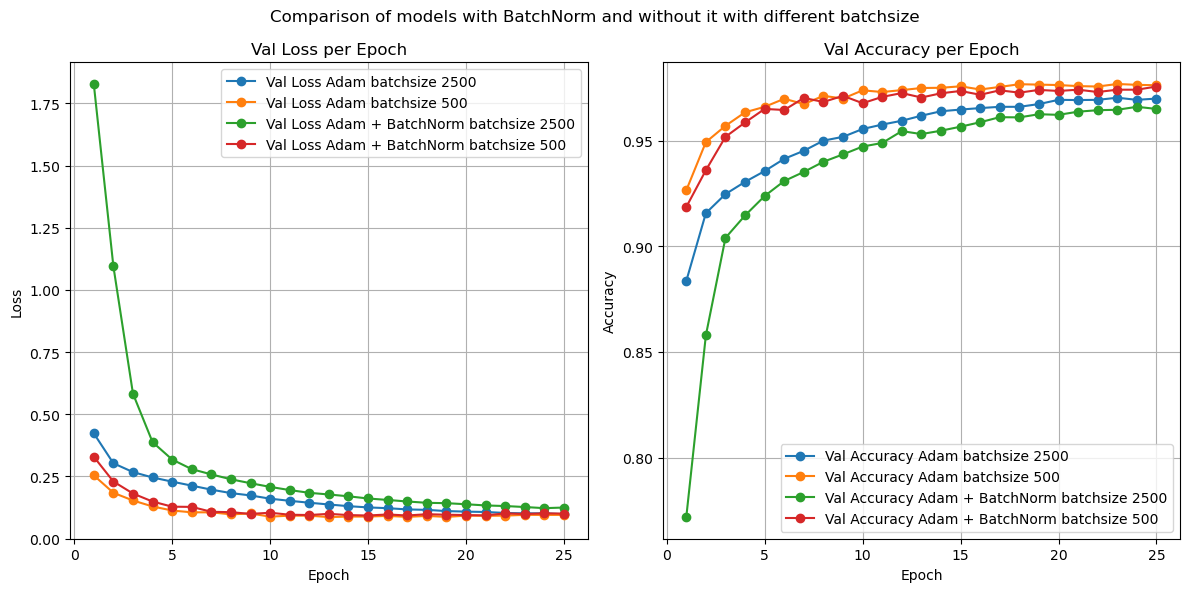

In [44]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_losses_relu) + 1), val_losses_relu, marker='o', label='Val Loss Adam batchsize 2500')
plt.plot(range(1, len(val_losses_relu3) + 1), val_losses_relu3, marker='o', label='Val Loss Adam batchsize 500')
plt.plot(range(1, len(val_losses_relu_bn) + 1), val_losses_relu_bn, marker='o', label='Val Loss Adam + BatchNorm batchsize 2500')
plt.plot(range(1, len(val_losses_relu_bn1) + 1), val_losses_relu_bn1, marker='o', label='Val Loss Adam + BatchNorm batchsize 500')
# plt.plot(range(1, len(val_losses_relu_sgd) + 1), val_losses_relu_sgd, marker='o', label='Test Loss SGD')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss per Epoch')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_relu) + 1), val_accuracies_relu, marker='o', label='Val Accuracy Adam batchsize 2500')
plt.plot(range(1, len(val_accuracies_relu3) + 1), val_accuracies_relu3, marker='o', label='Val Accuracy Adam batchsize 500')
plt.plot(range(1, len(val_accuracies_relu_bn) + 1), val_accuracies_relu_bn, marker='o',  label='Val Accuracy Adam + BatchNorm batchsize 2500')
plt.plot(range(1, len(val_accuracies_relu_bn1) + 1), val_accuracies_relu_bn1, marker='o',  label='Val Accuracy Adam + BatchNorm batchsize 500')
# plt.plot(range(1, len(val_accuracies_relu_sgd) + 1), val_accuracies_relu_sgd, marker='o',label='Test Accuracy SGD' )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of models with BatchNorm and without it with different batchsize')
plt.tight_layout()

plt.show()

Приведены графики моделей с активацией ReLU, отличаются только размером батча и наличием BatchNormalisation


**BatchNormalisation**

* Написано, что BatchNorm улучшает численную сходимость. В данном случае в результате экспериментов с шагом обучения, был момент, когда происходило переполнение градиента (взрыв) и применение BatchNorm помогло справится с этой проблемой.
* В данном случае получается небольшое различие с применением BatchNorm и без, но в итоге обе модели сходятся практически к одному значению accuracy.
* Из минусов можно отметить зависимость от размера бача и наличие дополнительных вычислений.
* Размер бача влияет на скорость сходимости, и на стабильность кривой обучения, с большим размером бача получается меньшее количество колебаний в процессе обучения

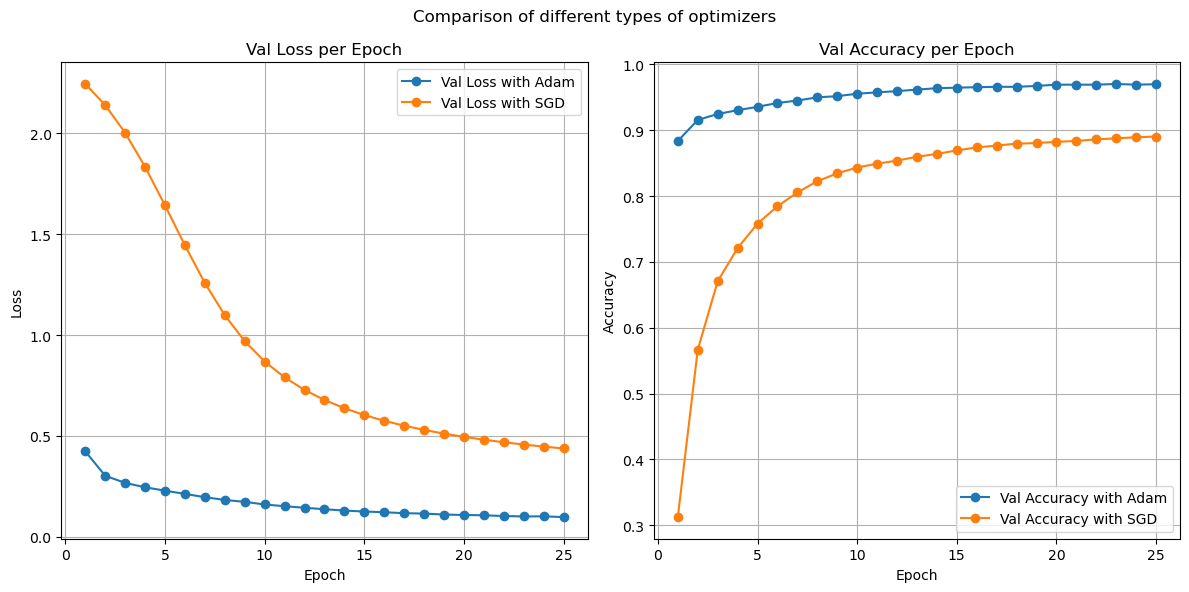

In [45]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_losses_relu) + 1), val_losses_relu, marker='o', label='Val Loss with Adam')
# plt.plot(range(1, len(val_losses_relu1) + 1), val_losses_relu1, marker='o', label='Test Loss w/o BatchNorm Adam')
plt.plot(range(1, len(val_losses_sgd) + 1), val_losses_sgd, marker='o', label='Val Loss with SGD')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss per Epoch')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_relu) + 1), val_accuracies_relu, marker='o', label='Val Accuracy with Adam')
# plt.plot(range(1, len(val_accuracies_relu1) + 1), val_accuracies_relu1, marker='o',  label='Test Accuracy w/o BatchNorm Adam')
plt.plot(range(1, len(val_accuracies_sgd) + 1), val_accuracies_sgd, marker='o',label='Val Accuracy with SGD' )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy per Epoch')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of different types of optimizers')
plt.tight_layout()

plt.show()

На графиках показана кривая обучения одной и той же модели с использованием разных оптимизаторов

**Различные оптимизаторы**
* SGD медленнее сходится и сходится к более высокому значению лосса нежели Adam
* Adam выходит на плато по точности приблизительно за 15 эпох, в то время как accuracy у SGD все еще растет, но на более низких значениях и за 25 эпох не достигает показателей Adam. 

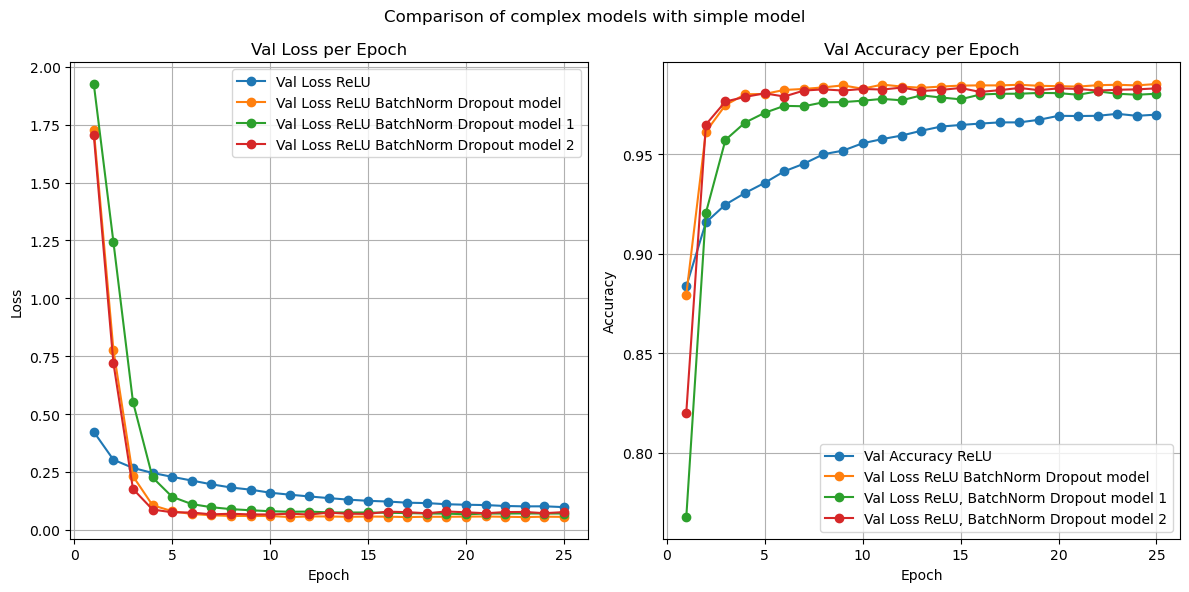

In [46]:
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_losses_relu) + 1), val_losses_relu, marker='o', label='Val Loss ReLU')
# plt.plot(range(1, len(val_losses_relu_bn) + 1), val_losses_relu_bn, marker='o', label='Test Loss with ReLU and BatchNorm')
plt.plot(range(1, len(val_losses_final) + 1), val_losses_final, marker='o', label='Val Loss ReLU BatchNorm Dropout model')
plt.plot(range(1, len(val_losses_final1) + 1), val_losses_final1, marker='o', label='Val Loss ReLU BatchNorm Dropout model 1')
plt.plot(range(1, len(val_losses_final2) + 1), val_losses_final2, marker='o', label='Val Loss ReLU BatchNorm Dropout model 2')



plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_relu) + 1), val_accuracies_relu, marker='o',  label='Val Accuracy ReLU')
# plt.plot(range(1, len(val_accuracies_relu_bn) + 1), val_accuracies_relu_bn, marker='o',  label='Test Accuracy with ReLU and BatchNorm')
plt.plot(range(1, len(val_accuracies_final) + 1), val_accuracies_final, marker='o', label='Val Loss ReLU BatchNorm Dropout model')
plt.plot(range(1, len(val_accuracies_final1) + 1), val_accuracies_final1, marker='o', label='Val Loss ReLU, BatchNorm Dropout model 1')
plt.plot(range(1, len(val_accuracies_final2) + 1), val_accuracies_final2, marker='o', label='Val Loss ReLU, BatchNorm Dropout model 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy per Epoch')
# plt.yscale('log')
plt.grid(True)
plt.legend()
plt.suptitle('Comparison of complex models with simple model')
plt.tight_layout()

plt.show()

**Сравнение простой модели со сложными**

Приведены графики 4 моделей:
* 2 четырех слойных модели отличающихся числом нейронов на линейных слоях и числом Dropout слоев.
* 1 пятислойная модель.
* Модель из 2 линейных слоев с ReLU активацией из первой части


По графикам видно что более сложные модели выходят на более высокий уровень accuracy нежели модель 2-хслойная модель. Однако дальнейшее более сильное увеличение сложности модели не дает существенного увеличение accuracy. 
Хотя если смотреть численные значения, то близкое к самому высокому значению accuracy, которое получено с самой простой из "сложных" моделей, полученно с моделью с самым большим количеством слоев.

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [47]:
# Your answer goes here. ################################################

# ответы под графиками

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [48]:
# Your code goes here. ################################################

# ответы под графиками

Print here your accuracy on test set. It should be around 90%.

In [49]:
print("Accuracy и Loss на тестовых данных для обученных моделей")
labels = ["ReLU", "ELU", "SoftPlus", "LeakyReLU", "ReLU BatchNorm", "ReLU SGD", "ReLU BatchNorm Dropout model", "ReLU BatchNorm Dropout model 1", "ReLU BatchNorm Dropout model 2"]
test_acc = [ acc_relu, acc_elu, acc_softplus, acc_leaky, acc_relu_bn, acc_sgd, acc_final, acc_final1, acc_final2]
test_loss = [ loss_relu, loss_elu, loss_softplus, loss_leaky, loss_relu_bn, loss_sgd, loss_final, loss_final1, loss_final2]
for acc, loss, text in zip(test_acc, test_loss, labels):

    print(f"accuracy: {acc:.4f}    {text}")

Accuracy и Loss на тестовых данных для обученных моделей
accuracy: 0.9708    ReLU
accuracy: 0.9708    ELU
accuracy: 0.9675    SoftPlus
accuracy: 0.9718    LeakyReLU
accuracy: 0.9634    ReLU BatchNorm
accuracy: 0.8839    ReLU SGD
accuracy: 0.9841    ReLU BatchNorm Dropout model
accuracy: 0.9790    ReLU BatchNorm Dropout model 1
accuracy: 0.9836    ReLU BatchNorm Dropout model 2


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset


X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_train = X_train.view(-1, 784)  
X_val = X_val.view(-1, 784)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



class MNISTLinearClassifier(nn.Module):
    def __init__(self):
        super(MNISTLinearClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = MNISTLinearClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 20
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in val_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        _, target_labels = torch.max(target, 1)
        total += target.size(0)
        correct += (predicted == target_labels).sum().item()

    print(f"Test Accuracy: {(100 * correct / total):.2f}%")

Epoch [1/20], Step [100/782], Loss: 0.3986
Epoch [1/20], Step [200/782], Loss: 0.4177
Epoch [1/20], Step [300/782], Loss: 0.4516
Epoch [1/20], Step [400/782], Loss: 0.1578
Epoch [1/20], Step [500/782], Loss: 0.1483
Epoch [1/20], Step [600/782], Loss: 0.0436
Epoch [1/20], Step [700/782], Loss: 0.0211
Epoch [2/20], Step [100/782], Loss: 0.0726
Epoch [2/20], Step [200/782], Loss: 0.0515
Epoch [2/20], Step [300/782], Loss: 0.0872
Epoch [2/20], Step [400/782], Loss: 0.0200
Epoch [2/20], Step [500/782], Loss: 0.1344
Epoch [2/20], Step [600/782], Loss: 0.2449
Epoch [2/20], Step [700/782], Loss: 0.1182
Epoch [3/20], Step [100/782], Loss: 0.0260
Epoch [3/20], Step [200/782], Loss: 0.1112
Epoch [3/20], Step [300/782], Loss: 0.0166
Epoch [3/20], Step [400/782], Loss: 0.0569
Epoch [3/20], Step [500/782], Loss: 0.0661
Epoch [3/20], Step [600/782], Loss: 0.0394
Epoch [3/20], Step [700/782], Loss: 0.1172
Epoch [4/20], Step [100/782], Loss: 0.0755
Epoch [4/20], Step [200/782], Loss: 0.1073
Epoch [4/20

С помощью PyTorch получаем модель сопоставимую по точности с нашей моделью. 
* PyTorch accuracy: **0.9802**
* Моя модель с 4 линейными слоями c BatchNormalization дала accuracy: **0.9841**